Run scraper
<br>
Create fighter_bouts_joined table from scraped_data.db using <project_root>/SQL/fighter_botus_join_query.sql
<br>
clean data

Questions:
- is harder to predict fights as rankings increase?

SLpM - Significant Strikes Landed per Minute

Str. Acc. - Significant Striking Accuracy

SApM - Significant Strikes Absorbed per Minute

Str. Def. - Significant Strike Defence (the % of opponents strikes that did not land)

TD Avg. - Average Takedowns Landed per 15 minutes

TD Acc. - Takedown Accuracy

TD Def. - Takedown Defense (the % of opponents TD attempts that did not land)

Sub. Avg. - Average Submissions Attempted per 15 minutes

In [1]:
import os, sys
from pathlib import Path
import pandas as pd
import sqlite3
import processor
import numpy as np

sys.path.insert(0, os.path.abspath('/home/justin/pycharmprojects/fight_predictor/predictor/'))
# pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# project_root = Path("/home/justin/projects/fight_predictor")
project_root = Path("/home/justin/pycharmprojects/fight_predictor")
data_dir = project_root / "predictor" / "Data" / "Scraped_Data"
scrapers_dir = project_root / "predictor" / "scrapers"
# fighters = pd.read_csv(data_dir / "scraped_fighters.csv")

In [3]:
dbpath = scrapers_dir  / 'db' / 'scraped_data.db'
print(dbpath)
# /home/justin/pycharmprojects/fight_predictor/predictor/scrapers/db/scraped_data.db

/home/justin/pycharmprojects/fight_predictor/predictor/scrapers/db/scraped_data.db


In [4]:
cnx = sqlite3.connect(dbpath)

Run if fighter_bouts_join table doesn't exist

In [5]:
# with (project_root / "SQL" / "fighter_bouts_join_query.sql").open() as sql_file:
#     sql_script = sql_file.read()
#     cnx.cursor().executescript(sql_script)
#     cnx.commit()
#     cnx.close()



#fbjdb.to_csv(data_dir / "fighter_bouts_joined.csv")

In [12]:
fdf = pd.read_sql_query("SELECT * FROM fighters", cnx)
bdf = pd.read_sql_query("SELECT * FROM bouts", cnx)
fbdf = pd.read_sql_query("SELECT * FROM fighter_bouts_joined", cnx)

In [13]:
replacedash = lambda x: np.nan if x == "--" else x
fdf["dob"] = fdf["date_of_birth"].apply(replacedash)
fdf["dob"] = pd.to_datetime(fdf["dob"])
# fdf.head(20)

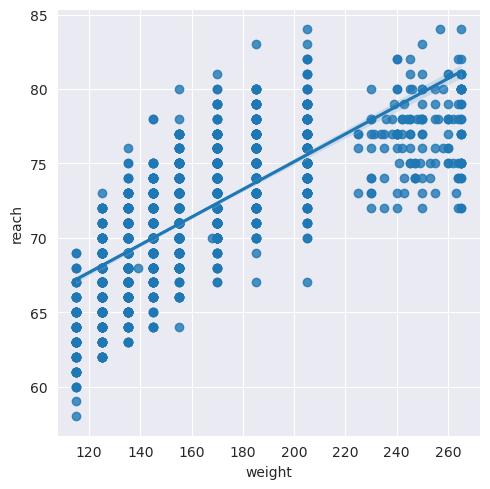

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

tempdf = fdf[["weight", "reach"]].dropna()
sns.lmplot(data=tempdf, x="weight", y="reach")
plt.show()

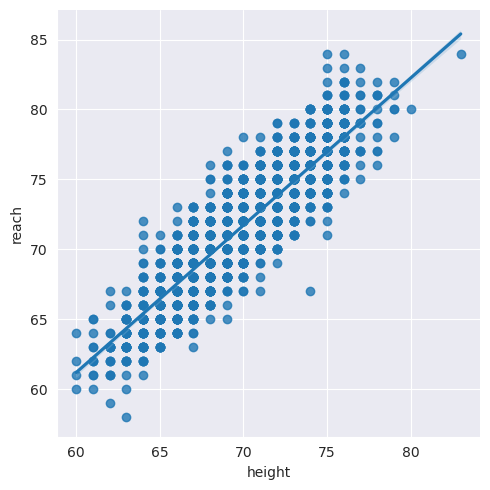

In [15]:
def parse_fighter_height(height):
    if height:
        if '"' in height:
            height = height.replace('"', '')
        ht = height.split("' ")
        ft = float(ht[0])
        inch = float(ht[1])

        return (12 * ft) + inch
    else:
        pass

fdf = fdf[fdf["height"] != "--"]
fdf["height"] = fdf["height"].apply(lambda x: parse_fighter_height(x))
tempdf = fdf[["height", "reach"]].dropna()
sns.lmplot(data=tempdf, x="height", y="reach")
plt.show()

In [16]:
# import re
# # s = "Record: 19-7-1 (1 NC)"
# s2 = "Record: 9-7-1"
# s3 = "Record: 90-7-1"
# s4 = "Record: 19-7-1"
# s5 = "Record: 534-7-1"
# # val = re.search('\(([^)]+)', s2)
#
# # sp = s2.split("-")
# # sp = s3.split("-")
# # sp = s4.split("-")
# sp = s5.split("-")
# print(sp)
# match = re.search('[0-9]+', sp[0])
# print(match)
# i = match.start()
# j = match.end()
# print(i, j)
# print(sp[0][i:j])

In [18]:
import re
def parse_nocontest(x):
    if "NC" in x:
        nc_record = re.search('\(([^)]+)', x).group(1)[0]
        return int(nc_record)
    return 0

def parse_record(x):
    sp = x.split("-")
    match = re.search('[0-9]+', sp[0])
    win = int(sp[0][match.start():match.end()])
    loss, draw = int(sp[1]), int(sp[2][0])
    return pd.Series([win, loss, draw])

fdf["no_contest"] = fdf.fighter_record.apply(parse_nocontest)
fdf[["win", "loss", "draw"]] = fdf.fighter_record.apply(parse_record)
fdf["total_fights"] = fdf["win"] + fdf["loss"] + fdf["draw"] + fdf["no_contest"]
fdf["win_loss_ratio"] = (fdf["win"] / fdf["loss"]).round(3)
fdf

,date_of_birth,fighter_name,fighter_record,height,reach,sapm,slpm,stance,strike_acc,strike_def,...,td_avg,td_def,weight,dob,no_contest,win,loss,draw,total_fights,win_loss_ratio
0,Mar 02 1992,Hunter Azure,Record: 9-2-0,68.0,69.0,2.08,3.92,Orthodox,53,58,...,1.97,67,145.0,1992-03-02,0,9,2,0,11,4.500
1,Jul 17 1990,Michael Byrnes,Record: 5-3-0,71.0,NaN,0.00,0.00,,0,0,...,0.00,0,155.0,1990-07-17,0,5,3,0,8,1.667
2,Feb 07 1989,Gleidson Cutis,Record: 7-4-0,69.0,NaN,8.28,2.99,Orthodox,52,59,...,0.00,0,155.0,1989-02-07,0,7,4,0,11,1.750
3,Aug 11 1990,Rolando Dy,Record: 9-7-1 (1 NC),68.0,69.0,4.47,3.04,Orthodox,37,52,...,0.30,68,145.0,1990-08-11,1,9,7,1,18,1.286
4,Jul 27 1986,Jessica Eye,Record: 15-11-0 (1 NC),66.0,66.0,4.19,3.86,Orthodox,37,55,...,0.58,57,125.0,1986-07-27,1,15,11,0,27,1.364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3917,Jun 29 1983,Ricky Rainey,Record: 12-6-0,73.0,77.0,2.62,2.55,Switch,48,46,...,0.95,55,170.0,1983-06-29,0,12,6,0,18,2.000
3918,Dec 07 1974,Amir Rahnavardi,Record: 11-10-0,72.0,NaN,0.00,0.67,Orthodox,25,100,...,0.00,50,205.0,1974-12-07,0,11,10,0,21,1.100
3919,Jan 06 1981,Josh Rafferty,Record: 9-8-0,72.0,NaN,3.60,0.60,Orthodox,33,50,...,0.00,0,170.0,1981-01-06,0,9,8,0,17,1.125
3920,--,Gilbert Rael,Record: 1-3-0,68.0,NaN,7.46,0.00,,0,37,...,4.86,0,155.0,NaT,0,1,3,0,4,0.333


In [21]:
fdf.columns

Index(['date_of_birth', 'fighter_name', 'fighter_record', 'height', 'reach',
       'sapm', 'slpm', 'stance', 'strike_acc', 'strike_def', 'sub_avg',
       'td_acc', 'td_avg', 'td_def', 'weight', 'dob', 'no_contest', 'win',
       'loss', 'draw', 'total_fights', 'win_loss_ratio'],
      dtype='object')

/tmp/ipykernel_23024/2892447162.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(corcolsdf.corr())


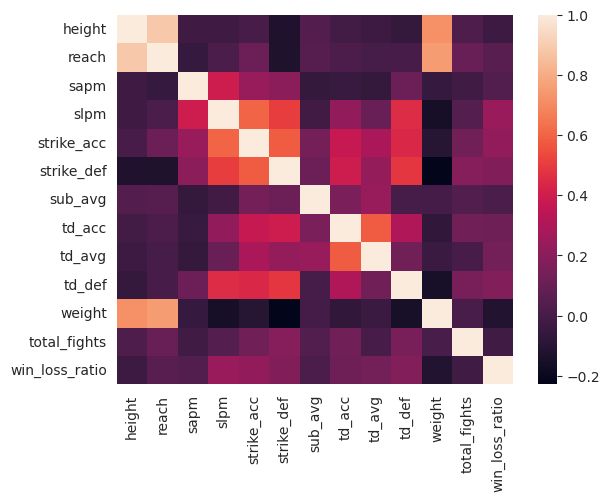

In [35]:
# columns = ['date_of_birth', 'fighter_name', 'fighter_record', 'height', 'reach',
#        'sapm', 'slpm', 'stance', 'strike_acc', 'strike_def', 'sub_avg',
#        'td_acc', 'td_avg', 'td_def', 'weight', 'dob', 'no_contest', 'win',
#        'loss', 'draw', 'total_fights', 'win_loss_ratio']
correlation_columns  = ['height', 'reach', 'sapm', 'slpm', 'stance', 'strike_acc', 'strike_def', 'sub_avg',
                        'td_acc', 'td_avg', 'td_def', 'weight', 'total_fights', 'win_loss_ratio']
# sns.pairplot(fdf[correlation_columns])
corcolsdf = fdf[correlation_columns]
sns.heatmap(corcolsdf.corr())
plt.show()

In [73]:
# Create correlation matrix
corr_matrix = corcolsdf.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

/tmp/ipykernel_23024/759920943.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = corcolsdf.corr().abs()
/tmp/ipykernel_23024/759920943.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


,height,reach,sapm,slpm,strike_acc,strike_def,sub_avg,td_acc,td_avg,td_def,weight,total_fights,win_loss_ratio
height,NaN,0.886682,0.026945,0.025116,0.004225,0.125101,0.039170,0.011122,0.028370,0.059111,0.721169,0.021847,0.029938
reach,NaN,NaN,0.051903,0.014394,0.106956,0.131637,0.045924,0.019781,0.002839,0.004336,0.754674,0.099298,0.051564
sapm,NaN,NaN,NaN,0.392377,0.236867,0.199059,0.060423,0.045028,0.060320,0.107427,0.053435,0.017971,0.032509
slpm,NaN,NaN,NaN,NaN,0.600271,0.503456,0.013903,0.217709,0.102121,0.457282,0.156833,0.040986,0.243330
strike_acc,NaN,NaN,NaN,NaN,NaN,0.578615,0.138093,0.372469,0.288176,0.439767,0.101481,0.124388,0.217832
strike_def,NaN,NaN,NaN,NaN,NaN,NaN,0.111642,0.390338,0.229358,0.483691,0.229138,0.187791,0.172087
sub_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.154250,0.240867,0.000852,0.005250,0.032727,0.013311
td_acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.580101,0.305049,0.066839,0.122386,0.115949
td_avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.128602,0.040356,0.004531,0.134957
td_def,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150556,0.147358,0.176628


In [ ]:
# Correlated pairs
# (height, reach) .8
# (strike_acc, slpm) .6
# (strike_def, slpm) .5
# (strike_acc, strike_def) .57
# (td_acc, td_avg) .58
# (weight, height) .72
# (weight, reach) .75

In [19]:
# import utils
# path = project_root / "predictor"
# xtrain, ytrain, xtest, ytest = utils.get_train_test_data(path, "Fight_Stats")


Processed_Data/FightStats/data.npz is the processed data from fighters_bouts_joined table

This data gets fed to FightStatsModel

In [9]:
print("yes")

yes


Processor class save_train..() method called at end of main creates

..Fight_Winner/Data/Processed_Data/data.npz. The df before save has 52 columns

Resulting df has the 8 target variables

In [74]:
base_dir = project_root / "predictor"
proc = processor.Processor(fbdf, base_dir)
# proc = Processor(fbjdf, base_dir)
# proc.read()
# proc.drop_unused_columns()
# proc.shuffle_winner_positions()
# proc.process_categorical_columns()
# proc.set_target()
# proc.impute()
# proc.scale()
# proc.stratify_shuffle()
# self.save_train_test_to_file('Fight_Winner')
proc.main()

event_attendence not dropped as it is not in dataframe


KeyboardInterrupt: 

In [11]:
len(proc.fight_bouts_bak.columns)

52

In [12]:
# /home/justin/pycharmprojects/fight_predictor/predictor/Notebooks/Data/Scraped_Data/fighters_bouts_joined.csv'

Processor class save_train..() method called at end of main creates

..Fight_Stats/Data/Processed_Data/data.npz. The df before save has 52 columns

Resulting df does NOT the 8 target variables

In [13]:
sp = processor.StatsProcessor(fbdf, base_dir)
# sp.read()
# sp.drop_unused_columns()
# sp.set_targets()
# sp.drop_targets_from_df()
# sp.shuffle_winner_positions()
# sp.process_categorical_columns()
# sp.fight_bouts.drop(columns='winner', inplace=True)
# sp.impute()
# sp.scale()
# sp.split_data()
# self.save_train_test_to_file('Fight_Stats', self.fight_stats_targets)
sp.main()

event_attendence not dropped as it is not in dataframe
saving at /home/justin/pycharmprojects/fight_predictor/predictor/Data/Processed_Data/Fight_Stats


In [14]:
len(sp.fight_bouts_bak.columns)

44

In [ ]:
import models

fsm = models.FightStatsModel()

2023-02-05 20:23:58.533913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 20:23:58.650160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 20:23:58.650176: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 20:23:59.788828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [ ]:
wm = models.WinnerModel()